In [4]:
import numpy as np
import cv2
import segment_image as seg
from ipm import inverse_perspective_mapping
from ipm import get_inv_ipm_transform
import matplotlib.pyplot as plt
import find_lane_lines as lanelines
from moviepy.editor import VideoFileClip

%matplotlib inline

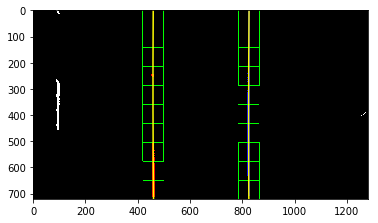

In [6]:
# Read in an image
img = cv2.imread('test_images/straight_lines2.jpg')

# Transform to inverse perspective mapping
ipm_img = inverse_perspective_mapping(img)
M_inv = get_inv_ipm_transform()

# Segmentation pipeline
seg_img = seg.segmentation_pipeline(ipm_img)

# Find lane fits
left_fit, right_fit, left_idx, right_idx, nzx, nzy, rect_corners = lanelines.find_lane_fit(seg_img)

# Plot lane fits
lanelines.plot_lane_fit(seg_img, left_fit, right_fit, left_idx, right_idx, nzx, nzy, rect_corners)

# Try drawing

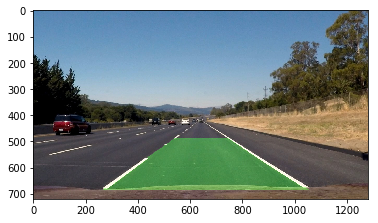

In [7]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(ipm_img).astype(np.uint8)
color_warp = warp_zero

# Recast the x and y points into usable format for cv2.fillPoly()
ploty = np.linspace(0, ipm_img.shape[0]-1, ipm_img.shape[0])
left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
poly_pts = np.squeeze(np.int_([pts]))
cv2.fillPoly(color_warp, np.int32([poly_pts]), (0,255,0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (seg_img.shape[1], seg_img.shape[0]))

# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

In [ ]:
result = lanelines.draw_nice_lane(img, ipm_img, seg_img, left_fit, right_fit, M_inv)

left_radius,right_radius, dist = lanelines.compute_radius_and_center_dist(ipm_img, left_fit, right_fit)
result = lanelines.draw_lane_details(result, (left_radius+right_radius)/2, dist)

plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))


In [ ]:
# Extrinsics
xm_per_pix = 3.7/350 # meters per pixel (the lane width seems to be 350 pixels, and is typically 3.7 meters)
ym_per_pix = 3.048/180 # meters per pixel ( the dashed line seems to be 180 pixels, and is typically 3.048 meters)

y_eval = ipm_img.shape[0]-1

# Fit new polynomials to x,y in world space
ploty = np.linspace(0, ipm_img.shape[0]-1, ipm_img.shape[0])
left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

vehicle_center = img.shape[1] / 2

left_x_pix  = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_x_pix = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
lane_center = (left_x_pix + right_x_pix) / 2

dist = (vehicle_center - lane_center) * xm_per_pix
print(dist, 'm')

In [2]:
def process_image(img):
    # Transform to inverse perspective mapping
    ipm_img = inverse_perspective_mapping(img)
    M_inv = get_inv_ipm_transform()

    # Segmentation pipeline
    seg_img = seg.segmentation_pipeline(ipm_img)

    # Find lane fits
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_idx, right_idx, nzx, nzy, rect_corners = lanelines.find_lane_fit(seg_img)
    else:
        left_fit, right_fit, left_idx, right_idx, nzx, nzy = lanelines.update_lane_fit(seg_img, left_line.best_fit, right_line.best_fit)
    
    left_line.update(left_fit, left_idx)
    right_line.update(right_fit, right_idx)
    
    # Draw lane fits
    best_left_fit  = left_line.best_fit
    best_right_fit = right_line.best_fit
    
    if best_left_fit is not None and best_right_fit is not None:
        # Draw lanes
        result = lanelines.draw_nice_lane(img, ipm_img, seg_img, best_left_fit, best_right_fit, M_inv)
        
        # Compute radius of curvature
        left_radius,right_radius, dist = lanelines.compute_radius_and_center_dist(ipm_img, left_fit, right_fit)
        
        # Draw details - radius and distance
        if left_radius is not None or right_radius is not None:
            result = lanelines.draw_lane_details(result, (left_radius+right_radius)/2, dist)
    else:
        result = img
    
    return result



In [ ]:
left_line  = lanelines.Line()
right_line = lanelines.Line() 

video_name = 'project_video.mp4'
video_output_name = 'project_video_track.mp4'
video_input = VideoFileClip(video_name)

processed_video = video_input.fl_image(process_image)

processed_video.write_videofile(video_output_name, audio=False)